In [15]:
# Install YOLOv11 and necessary dependencies
!pip install ultralytics

import os
import shutil
import matplotlib.pyplot as plt
import cv2
import random
from IPython.display import Image, display
import pandas as pd
import seaborn as sns
from ultralytics import YOLO

In [16]:
# Import wandb and log in
import wandb

# Log in to wandb with API key
wandb.login(key='8a1b95ea42f6c41ac024eae0d344b48f4b62a3f4')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [17]:
# Define paths
root_dir = '/kaggle/input/toothdecaydetection'
v1_dir = os.path.join(root_dir, '/kaggle/input/toothdecaydetection')

In [18]:
# Ensure the YOLOv11 data directories exist
os.makedirs('yolov11/data/caries_v1', exist_ok=True)

Displaying some training images from version 1:


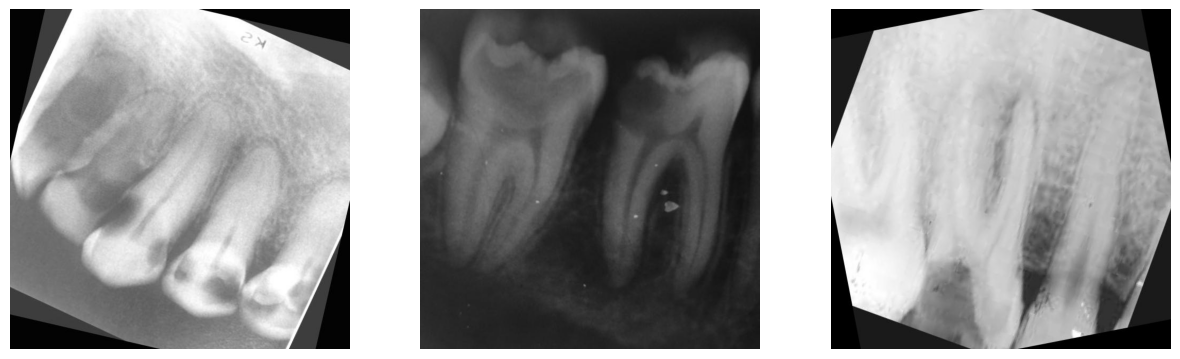

In [19]:
# Function to display images
def display_images(image_dir, num_images=3):
    images = os.listdir(image_dir)
    sample_images = random.sample(images, num_images)
    plt.figure(figsize=(15, 15))
    for i, image_name in enumerate(sample_images):
        image_path = os.path.join(image_dir, image_name)
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
    plt.show()

# Display some training images
print("Displaying some training images from version 1:")
display_images(os.path.join(v1_dir, 'train/images'))

In [20]:
# Copy dataset to YOLOv11 directory
def copy_dataset_to_yolo(src_dir, dest_dir):
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir)
    shutil.copytree(src_dir, dest_dir)

# Copy version 1 dataset
copy_dataset_to_yolo(v1_dir, 'yolov11/data/caries_v1')

In [21]:
# Update data.yaml paths
def update_data_yaml(data_yaml_path, base_dir):
    with open(data_yaml_path, 'r') as file:
        data_yaml = file.read()
    data_yaml = data_yaml.replace('../train/images', os.path.join(base_dir, 'train/images'))
    data_yaml = data_yaml.replace('../valid/images', os.path.join(base_dir, 'valid/images'))
    data_yaml = data_yaml.replace('../test/images', os.path.join(base_dir, 'test/images'))
    with open(data_yaml_path, 'w') as file:
        file.write(data_yaml)

# Update data.yaml for version 1
update_data_yaml('yolov11/data/caries_v1/data.yaml', '/kaggle/working/yolov11/data/caries_v1')

# Print and verify updated data.yaml files
def print_data_yaml(data_yaml_path):
    with open(data_yaml_path, 'r') as file:
        print(file.read())

print("Updated data.yaml for version 1:")
print_data_yaml('yolov11/data/caries_v1/data.yaml')



Updated data.yaml for version 1:
train: /kaggle/working/yolov11/data/caries_v1/train/images
val: /kaggle/working/yolov11/data/caries_v1/valid/images
test: /kaggle/working/yolov11/data/caries_v1/test/images

nc: 2
names: ['Dentin_Caries', 'Pulpitis_Caries']

roboflow:
  workspace: cocoyaml
  project: tooth-decay-dectection-6hjk3-lvwpt
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/cocoyaml/tooth-decay-dectection-6hjk3-lvwpt/dataset/1


In [22]:
# EDA and Preprocessing
def load_labels(label_dir):
    label_files = os.listdir(label_dir)
    data = []
    for label_file in label_files:
        with open(os.path.join(label_dir, label_file), 'r') as file:
            lines = file.readlines()
            for line in lines:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                data.append([label_file, class_id, x_center, y_center, width, height])
    df = pd.DataFrame(data, columns=['file', 'class_id', 'x_center', 'y_center', 'width', 'height'])
    return df

v1_train_labels = load_labels(os.path.join(v1_dir, 'train/labels'))


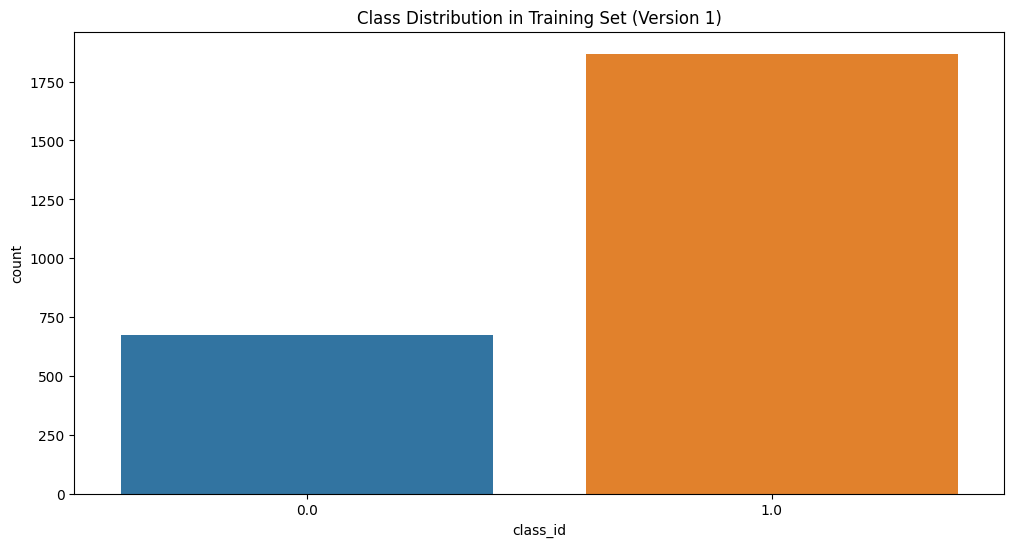

In [23]:
# Plot class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=v1_train_labels, x='class_id')
plt.title('Class Distribution in Training Set (Version 1)')
plt.show()

In [24]:
AUGMENTATION = False

if AUGMENTATION:
    augment_transform = Compose([
        HorizontalFlip(p=0.5),
        RandomRotate90(p=0.5),
        ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
        RandomBrightnessContrast(p=0.5),
        HueSaturationValue(p=0.5),
    ], bbox_params={'format': 'yolo', 'label_fields': ['labels']})

    def augment_images(destination_folder, minority_classes, num_aug=5):
        label_folder = os.path.join(destination_folder, 'labels')
        image_folder = os.path.join(destination_folder, 'images')

        for label_file in os.listdir(label_folder):
            label_path = os.path.join(label_folder, label_file)
            image_file = label_file.replace('.txt', '.jpg')
            image_path = os.path.join(image_folder, image_file)

            if not os.path.exists(image_path):
                continue

            # Đọc nhãn
            with open(label_path, 'r') as f:
                lines = f.readlines()

            # Kiểm tra xem ảnh này có chứa lớp thiếu hay không
            contains_minority = False
            labels = []
            for line in lines:
                parts = line.strip().split()
                if len(parts) < 5:
                    continue
                class_id = int(parts[0])
                if class_id in minority_classes:
                    contains_minority = True
                labels.append(parts)

            if not contains_minority:
                continue

            # Đọc ảnh
            image = cv2.imread(image_path)
            if image is None:
                continue

            # Chuyển đổi labels thành list of dicts cho albumentations
            bboxes = []
            bbox_labels = []
            for parts in labels:
                class_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:])
                bboxes.append([x_center, y_center, width, height])
                bbox_labels.append(class_id)

            # Áp dụng augmentations và lưu lại
            for i in range(num_aug):
                augmented = augment_transform(image=image, bboxes=bboxes, labels=bbox_labels)
                aug_image = augmented['image']
                aug_bboxes = augmented['bboxes']
                aug_labels = augmented['labels']

                if not aug_bboxes:
                    continue  # Nếu không còn bounding boxes sau augmentation

                # Lưu ảnh đã augment
                aug_image_file = label_file.replace('.txt', f'_aug_{i}.jpg')
                aug_image_path = os.path.join(image_folder, aug_image_file)
                cv2.imwrite(aug_image_path, aug_image)

                # Chuyển đổi bounding boxes sang định dạng YOLO và ghi lại
                aug_label_file = label_file.replace('.txt', f'_aug_{i}.txt')
                aug_label_path = os.path.join(label_folder, aug_label_file)
                with open(aug_label_path, 'w') as f:
                    for bbox, cls_id in zip(aug_bboxes, aug_labels):
                        f.write(f"{cls_id} {' '.join(map(str, bbox))}\n")

        print("Data augmentation completed.")

    # Áp dụng augmentations cho các lớp thiếu
    threshold = 25000
    minority_classes = [cls for cls, count in train_class_count.items() if count < threshold]
    print("Minority Classes:", minority_classes)

    augment_images(train_folder, minority_classes, num_aug=5)

    # Tạo lại danh sách file sau khi augment
    train_image_files = os.listdir(os.path.join(train_folder, 'images'))
    train_label_files = os.listdir(os.path.join(train_folder, 'labels'))

    print(f"Train set after augmentation: {len(train_image_files)} images")

In [25]:
from ultralytics import YOLO
# Train YOLOv11 model with augmentation and hyperparameter tuning
# Initialize model
model = YOLO("yolo11n.pt")

In [26]:
# Train model on version 1 dataset
#AUGMENT = True
model.train(data='/kaggle/input/toothdecaydetection/data.yaml',  # Path to dataset
epochs=150, 
    imgsz=640, 
    batch=16, 
    name='caries_v1_aug',
    lr0=0.0001,                   # Further reduced initial learning rate
    lrf=0.2,                     # Final learning rate scaling factor
    hsv_h=0.015,                 # Hue variation for augmentation
    hsv_s=0.7,                   # Saturation variation for augmentation
    hsv_v=0.4,                   # Value variation for augmentation
    degrees=0.0,                 # No rotation
    translate=0.1,               # Slight translation for generalization
    scale=0.6,                   # Scaling for small object variation
    shear=0.0,                   # No shear
    perspective=0.0,             # No perspective change
    flipud=0.2,                  # Vertical flip probability
    fliplr=0.5,                  # 50% chance for horizontal flip
    mosaic=0.65,                 # Slight increase in mosaic augmentation
    mixup=0.1,                   # Add light mixup for variability
    cls=1.2,                     # Adjusted class loss weight
    box=2.5,                     # Maintain current box loss weight
    save_period=3,               # Save checkpoint every 3 epochs
    verbose=True                 # Output true
)



Ultralytics 8.3.68 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/input/toothdecaydetection/data.yaml, epochs=150, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=3, cache=False, device=None, workers=8, project=None, name=caries_v1_aug, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_la

100%|██████████| 755k/755k [00:00<00:00, 22.7MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/input/toothdecaydetection/train/labels... 1764 images, 90 backgrounds, 0 corrupt: 100%|██████████| 1764/1764 [00:02<00:00, 816.05it/s]

train: WARNING ⚠️ Cache directory /kaggle/input/toothdecaydetection/train is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.1 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/input/toothdecaydetection/valid/labels... 169 images, 7 backgrounds, 0 corrupt: 100%|██████████| 169/169 [00:00<00:00, 433.11it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/toothdecaydetection/valid is not writeable, cache not saved.


Plotting labels to runs/detect/caries_v1_aug/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/caries_v1_aug
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      2.67G     0.7145      8.317      1.998         14        640: 100%|██████████| 111/111 [00:26<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

                   all        169        266       0.73      0.186      0.274      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      2.69G     0.6743      6.344      1.866         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.82it/s]

                   all        169        266      0.432      0.361      0.381      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      2.68G     0.6657      5.521      1.829          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.85it/s]

                   all        169        266      0.308      0.138      0.131     0.0494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150       2.7G     0.6624      5.152      1.849          5        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.98it/s]

                   all        169        266      0.684       0.43      0.493      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      2.69G     0.6466      4.674      1.818          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]

                   all        169        266      0.526      0.453      0.516      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      2.67G     0.6452      4.478      1.795          4        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.47it/s]

                   all        169        266      0.646      0.545      0.553      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      2.67G     0.6464       4.36      1.821         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]

                   all        169        266      0.612       0.49      0.554      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      2.68G     0.6341      4.357      1.812          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.55it/s]

                   all        169        266       0.55      0.517      0.535       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      2.69G     0.6355      4.214       1.79          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.40it/s]

                   all        169        266      0.655      0.619      0.642      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      2.67G     0.6353      4.133      1.778         13        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.16it/s]

                   all        169        266      0.582      0.591      0.597      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      2.67G     0.6172      3.956      1.746          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]

                   all        169        266      0.703      0.671      0.707      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      2.68G     0.6237       3.95      1.761         20        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]

                   all        169        266      0.619      0.615      0.623      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      2.69G     0.6207      3.864      1.738          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.83it/s]

                   all        169        266      0.738      0.667      0.719      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      2.66G     0.6162      3.783      1.749          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.38it/s]

                   all        169        266      0.631      0.562      0.592      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      2.67G      0.617       3.81      1.765          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.38it/s]

                   all        169        266      0.673      0.621      0.665      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      2.67G     0.6147       3.79       1.74         16        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.53it/s]

                   all        169        266      0.743      0.596       0.67      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      2.67G     0.6068      3.731      1.721          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]

                   all        169        266       0.73       0.62      0.684      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      2.66G     0.6046      3.584      1.721          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.41it/s]

                   all        169        266      0.638      0.624      0.648      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      2.72G     0.6101      3.679      1.705         17        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.57it/s]

                   all        169        266      0.778      0.648      0.725      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      2.67G     0.6034      3.597      1.714         14        640: 100%|██████████| 111/111 [00:23<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]

                   all        169        266      0.789      0.651      0.741      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      2.67G     0.6137      3.611      1.751          4        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]

                   all        169        266      0.687      0.603      0.669      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      2.67G     0.6088      3.453      1.726          4        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.01it/s]

                   all        169        266      0.691       0.72      0.721      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      2.69G     0.5981      3.483      1.717         15        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.47it/s]

                   all        169        266      0.782      0.564      0.663      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      2.71G     0.5902      3.409      1.677         14        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]

                   all        169        266      0.771      0.625       0.72       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      2.67G     0.5908      3.253       1.69          4        640: 100%|██████████| 111/111 [00:23<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.39it/s]

                   all        169        266      0.767      0.689      0.743      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      2.67G     0.5931      3.466      1.691         15        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]

                   all        169        266      0.643      0.683      0.666      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      2.67G     0.5935      3.441      1.679          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]

                   all        169        266      0.705      0.695      0.712      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150       2.7G     0.5804      3.282      1.673         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.50it/s]

                   all        169        266      0.761      0.641      0.704      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      2.69G     0.5899      3.402      1.674          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.38it/s]

                   all        169        266      0.781      0.702      0.729      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      2.68G     0.5866      3.268      1.681         15        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]

                   all        169        266      0.718      0.635       0.71      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      2.67G     0.5877      3.365      1.679          5        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]

                   all        169        266      0.653      0.703      0.703      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150       2.7G     0.5834      3.254      1.657         12        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.58it/s]

                   all        169        266      0.724      0.653      0.714      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      2.69G     0.5845      3.322      1.658          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.66it/s]

                   all        169        266      0.756      0.708      0.743      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      2.67G      0.587      3.289      1.669         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.49it/s]

                   all        169        266      0.795      0.662      0.757      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      2.67G     0.5789      3.081      1.658          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.40it/s]

                   all        169        266      0.766      0.719      0.751      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      2.67G     0.5852      3.203      1.673          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.81it/s]

                   all        169        266      0.827      0.733      0.785      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      2.67G      0.582      3.188      1.667         15        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.37it/s]

                   all        169        266      0.812      0.713      0.791      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150       2.7G     0.5764      3.123      1.653          5        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]

                   all        169        266      0.795      0.689      0.769      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      2.67G     0.5804      3.105      1.647          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]

                   all        169        266      0.814       0.69      0.758      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      2.67G     0.5798      3.207       1.65         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.54it/s]

                   all        169        266       0.85      0.651       0.75      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      2.67G     0.5767      3.182      1.658         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.52it/s]

                   all        169        266      0.789      0.691      0.751      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150       2.7G     0.5694      3.059      1.633          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.40it/s]

                   all        169        266      0.728      0.773       0.78      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      2.69G     0.5682      3.093      1.624          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]

                   all        169        266      0.723      0.707      0.743      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      2.71G     0.5718      3.025      1.635          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.37it/s]

                   all        169        266      0.782      0.688      0.756      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      2.66G      0.578      3.039       1.64          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.69it/s]

                   all        169        266      0.756       0.75      0.764       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      2.67G     0.5698      2.994      1.638          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.07it/s]

                   all        169        266      0.747       0.63      0.719      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      2.71G     0.5615      3.023      1.624          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.41it/s]

                   all        169        266      0.773      0.682      0.734      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      2.68G      0.574      2.991      1.622         14        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]

                   all        169        266      0.786      0.746      0.758      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      2.69G     0.5596       3.02      1.605         19        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.37it/s]

                   all        169        266      0.788      0.757      0.783      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      2.67G     0.5696       3.07      1.642          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.56it/s]

                   all        169        266      0.812      0.641      0.725      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      2.67G     0.5759      3.069      1.635          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]

                   all        169        266       0.79      0.718      0.749      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      2.66G     0.5673      2.939      1.615          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.60it/s]

                   all        169        266      0.819      0.734      0.757      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      2.67G     0.5532      2.851      1.587         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.45it/s]

                   all        169        266      0.811      0.734      0.784      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      2.66G       0.56      2.921      1.599          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]

                   all        169        266      0.818      0.718      0.754      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      2.67G     0.5661      2.923      1.628          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.70it/s]

                   all        169        266      0.791      0.718      0.751      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      2.67G     0.5589      2.926      1.611         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]

                   all        169        266      0.817       0.71      0.787      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      2.69G     0.5672      2.924      1.631         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]

                   all        169        266      0.869      0.739      0.792      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      2.67G     0.5564      2.911        1.6          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]

                   all        169        266      0.782      0.705      0.738      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      2.67G     0.5529      2.891      1.596         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.45it/s]

                   all        169        266      0.802      0.733      0.779       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      2.68G     0.5583      2.863      1.619          5        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.52it/s]

                   all        169        266      0.807      0.779      0.804      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      2.69G     0.5475      2.858      1.586          5        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.40it/s]

                   all        169        266      0.785      0.778      0.812      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      2.66G       0.55      2.887      1.599          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]

                   all        169        266      0.776      0.721      0.768      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      2.69G     0.5557      2.919      1.599         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.24it/s]

                   all        169        266      0.806      0.707      0.759      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150       2.7G     0.5443      2.749      1.569          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.72it/s]

                   all        169        266      0.813      0.693      0.752      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      2.67G     0.5553      2.851      1.591         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]

                   all        169        266      0.815      0.792      0.802       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      2.67G     0.5422      2.788      1.555          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]

                   all        169        266      0.802      0.794      0.798      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      2.69G     0.5449      2.812      1.572          2        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]

                   all        169        266      0.749      0.738      0.775      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      2.68G     0.5476      2.776       1.57          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]

                   all        169        266      0.824       0.74      0.783      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      2.69G     0.5524      2.839      1.588         13        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]

                   all        169        266      0.753      0.722      0.759      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      2.67G     0.5496      2.844       1.58          4        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.57it/s]

                   all        169        266      0.793      0.769      0.799      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      2.67G     0.5452       2.74      1.572          5        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.26it/s]

                   all        169        266      0.821      0.769      0.797      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      2.68G     0.5396      2.651      1.553          4        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]

                   all        169        266      0.824      0.771       0.81      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      2.67G     0.5429      2.674      1.573          5        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]

                   all        169        266      0.821       0.76       0.81      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      2.68G     0.5412      2.733      1.551          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]

                   all        169        266      0.775       0.77      0.786      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      2.69G     0.5494      2.732      1.566          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]

                   all        169        266      0.815      0.739      0.808      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      2.68G     0.5401        2.7      1.549         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]

                   all        169        266      0.826      0.725      0.804      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      2.67G     0.5496      2.715      1.578         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.57it/s]

                   all        169        266      0.823      0.743       0.79      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      2.68G     0.5412      2.731      1.566         18        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]

                   all        169        266      0.835      0.756      0.821      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      2.69G     0.5394      2.616       1.55          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.38it/s]

                   all        169        266       0.81      0.729      0.789      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      2.68G       0.54      2.691       1.56         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]

                   all        169        266      0.794      0.761      0.806      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      2.68G     0.5401      2.691      1.562          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]

                   all        169        266      0.825      0.754      0.791      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      2.67G     0.5422      2.697      1.554          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.20it/s]

                   all        169        266      0.813      0.766       0.81      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      2.71G     0.5369      2.582       1.54         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]

                   all        169        266      0.761      0.751      0.771      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150       2.7G     0.5293      2.544      1.538         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]

                   all        169        266      0.813      0.773      0.816      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      2.68G     0.5278      2.575      1.532          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.25it/s]

                   all        169        266        0.8       0.76      0.786      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      2.68G     0.5355      2.621      1.537          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.50it/s]

                   all        169        266      0.824      0.751      0.777      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      2.67G      0.535      2.605       1.54          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.59it/s]

                   all        169        266      0.806      0.783      0.819      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      2.68G     0.5319      2.624      1.547          3        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]

                   all        169        266      0.826       0.76      0.804      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      2.71G     0.5341      2.585      1.547         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]

                   all        169        266      0.816      0.743      0.801      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      2.67G     0.5301      2.606      1.548         12        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.41it/s]

                   all        169        266       0.78      0.741      0.772      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      2.67G      0.525      2.615       1.53          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.57it/s]

                   all        169        266      0.803      0.727      0.773      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      2.67G     0.5316      2.574      1.532         14        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.88it/s]

                   all        169        266      0.838      0.782      0.818      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      2.67G     0.5258       2.56       1.53          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]

                   all        169        266      0.803      0.785      0.819      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150       2.7G      0.528      2.522      1.507          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.44it/s]

                   all        169        266      0.815      0.775      0.817      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      2.69G     0.5269      2.517      1.528         14        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]

                   all        169        266      0.831      0.786      0.808      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      2.68G     0.5232      2.536       1.52          5        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.91it/s]

                   all        169        266      0.817      0.768      0.805      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      2.69G     0.5326      2.555      1.531         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.39it/s]

                   all        169        266      0.783      0.785      0.809      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150       2.7G     0.5278      2.564      1.527         13        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.48it/s]

                   all        169        266      0.818      0.772      0.814      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      2.67G     0.5195      2.497      1.515          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.35it/s]

                   all        169        266      0.854       0.77      0.812        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      2.68G     0.5183      2.452      1.509         13        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]

                   all        169        266      0.847      0.798       0.83      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      2.67G     0.5251      2.507      1.516         14        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.48it/s]

                   all        169        266      0.839      0.794       0.83      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      2.67G     0.5193      2.491      1.505          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]

                   all        169        266      0.831       0.77      0.816      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      2.69G     0.5246      2.449      1.516         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]

                   all        169        266       0.79      0.748      0.786      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      2.66G     0.5171      2.496      1.507          3        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.59it/s]

                   all        169        266      0.828      0.775      0.802      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      2.67G     0.5172      2.466      1.496          5        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.15it/s]

                   all        169        266      0.836       0.78      0.824      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150       2.7G     0.5203      2.457      1.488         14        640: 100%|██████████| 111/111 [00:23<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.05it/s]

                   all        169        266      0.859      0.776      0.822      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      2.67G      0.519      2.444      1.507         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.44it/s]

                   all        169        266      0.842      0.769      0.804      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      2.68G     0.5199      2.426      1.497          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.21it/s]

                   all        169        266      0.837      0.768        0.8       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      2.69G      0.521      2.454      1.505         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]

                   all        169        266      0.825      0.746      0.791      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      2.67G     0.5176      2.372      1.491          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.39it/s]

                   all        169        266      0.851       0.76      0.805      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      2.69G     0.5173      2.459      1.484          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]

                   all        169        266      0.821      0.763      0.793      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      2.69G     0.5179      2.378      1.506         13        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.55it/s]

                   all        169        266      0.837      0.769      0.799      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      2.69G     0.5201      2.428       1.49          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.55it/s]

                   all        169        266      0.831      0.775      0.796      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      2.66G     0.5158      2.419      1.493         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.53it/s]

                   all        169        266      0.825      0.774        0.8      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      2.69G     0.5128      2.345      1.486          4        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.80it/s]

                   all        169        266       0.85      0.778      0.806       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      2.68G     0.5094      2.331      1.471          2        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]

                   all        169        266      0.854      0.773      0.812      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      2.68G     0.5053      2.342      1.467          5        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.38it/s]

                   all        169        266      0.836      0.745      0.798      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      2.67G     0.5064      2.313       1.47          5        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.00it/s]

                   all        169        266      0.852      0.798      0.809       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      2.72G     0.5077      2.381      1.475         21        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.57it/s]

                   all        169        266      0.847      0.789      0.812      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      2.68G     0.5139      2.366      1.486         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]

                   all        169        266      0.826      0.761      0.808      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      2.71G     0.5103      2.383      1.476         16        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]

                   all        169        266       0.81      0.774      0.801      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      2.68G     0.5038      2.327      1.458         13        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.45it/s]

                   all        169        266      0.827      0.778      0.804      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      2.72G     0.5118      2.343      1.484          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.35it/s]

                   all        169        266      0.831      0.763      0.805      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      2.68G     0.5046      2.377      1.466          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]

                   all        169        266      0.857      0.747      0.799      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      2.69G     0.5016      2.321      1.477          4        640: 100%|██████████| 111/111 [00:23<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]

                   all        169        266      0.803       0.78      0.809      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      2.66G     0.4995      2.257      1.459          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.13it/s]

                   all        169        266      0.834      0.783      0.815      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      2.67G     0.5073      2.298      1.468         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]

                   all        169        266       0.83      0.788       0.82      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      2.71G     0.5052      2.311      1.474          8        640: 100%|██████████| 111/111 [00:23<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]

                   all        169        266       0.82      0.797      0.802      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      2.67G     0.5104        2.3      1.481          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.53it/s]

                   all        169        266      0.836      0.791      0.818      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      2.65G     0.5011      2.254      1.456          3        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.53it/s]

                   all        169        266      0.844      0.795      0.818      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      2.69G      0.495      2.223      1.446         11        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.37it/s]

                   all        169        266      0.829       0.73      0.786      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      2.68G     0.4955      2.248      1.457         13        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.48it/s]

                   all        169        266      0.821      0.797      0.805      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      2.69G     0.4953      2.208       1.45          9        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]

                   all        169        266      0.835      0.801      0.808      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150       2.7G     0.4958      2.266      1.445         12        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.27it/s]

                   all        169        266      0.816      0.785      0.802      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      2.67G     0.4955      2.253      1.458         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.51it/s]

                   all        169        266       0.84      0.776      0.801      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      2.67G     0.4985       2.31      1.459         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.50it/s]

                   all        169        266      0.812      0.792      0.801      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      2.68G     0.4929      2.212      1.443         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.51it/s]

                   all        169        266      0.841       0.78      0.815      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      2.67G      0.496      2.234      1.448          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.35it/s]

                   all        169        266      0.832      0.777      0.807      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      2.67G     0.4882      2.213      1.435         12        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.44it/s]

                   all        169        266        0.8      0.795      0.803      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      2.67G      0.487      2.175      1.437         16        640: 100%|██████████| 111/111 [00:23<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.32it/s]

                   all        169        266      0.813      0.793      0.811      0.401


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      2.67G     0.4591      1.732       1.41          8        640: 100%|██████████| 111/111 [00:24<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.43it/s]

                   all        169        266      0.803      0.816      0.809      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      2.65G     0.4569      1.728      1.418          4        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.54it/s]

                   all        169        266      0.844      0.757      0.785      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      2.67G     0.4589      1.698      1.416          7        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.02it/s]

                   all        169        266      0.853      0.782      0.809      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      2.66G     0.4532      1.661      1.407          5        640: 100%|██████████| 111/111 [00:23<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.52it/s]

                   all        169        266      0.842      0.782      0.814      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      2.66G     0.4604      1.675      1.421          4        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.23it/s]

                   all        169        266      0.818      0.789      0.803        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      2.65G     0.4526      1.653      1.402          4        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.44it/s]

                   all        169        266      0.844      0.778      0.801      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      2.67G     0.4443      1.645      1.376         10        640: 100%|██████████| 111/111 [00:23<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.28it/s]

                   all        169        266      0.859      0.759      0.809        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      2.66G     0.4448      1.633      1.381          6        640: 100%|██████████| 111/111 [00:23<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.09it/s]

                   all        169        266      0.863      0.771      0.813      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      2.66G     0.4498      1.617      1.396          5        640: 100%|██████████| 111/111 [00:23<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]

                   all        169        266      0.859      0.758      0.809      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      2.65G     0.4428      1.613      1.385          4        640: 100%|██████████| 111/111 [00:23<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.50it/s]

                   all        169        266      0.779      0.806      0.803      0.393



150 epochs completed in 1.057 hours.
Optimizer stripped from runs/detect/caries_v1_aug/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/caries_v1_aug/weights/best.pt, 5.5MB

Validating runs/detect/caries_v1_aug/weights/best.pt...
Ultralytics 8.3.68 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]


                   all        169        266      0.836       0.78      0.825      0.408
         Dentin_Caries         54         85      0.797      0.671      0.752      0.332
       Pulpitis_Caries        141        181      0.875       0.89      0.897      0.483


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/caries_v1_aug


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x784cc2a47c70>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

Displaying results from model trained on version 1 with augmentation:

image 1/1 /kaggle/input/toothdecaydetection/test/images/1213_jpg.rf.675b8edffbe24fa13d4f250b24b1b8f1.jpg: 640x640 3 Dentin_Cariess, 9.8ms
Speed: 1.8ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


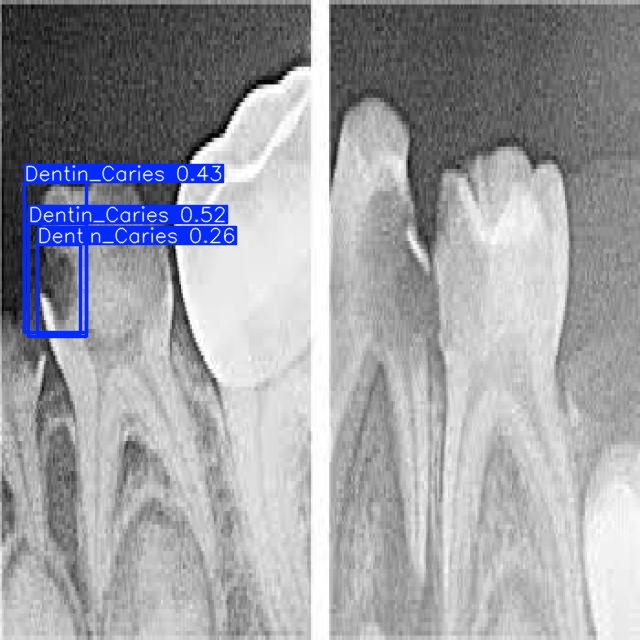


image 1/1 /kaggle/input/toothdecaydetection/test/images/108_jpg.rf.b6781734b689bd8d9397769d7b0e9f2d.jpg: 640x640 (no detections), 8.2ms
Speed: 1.5ms preprocess, 8.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


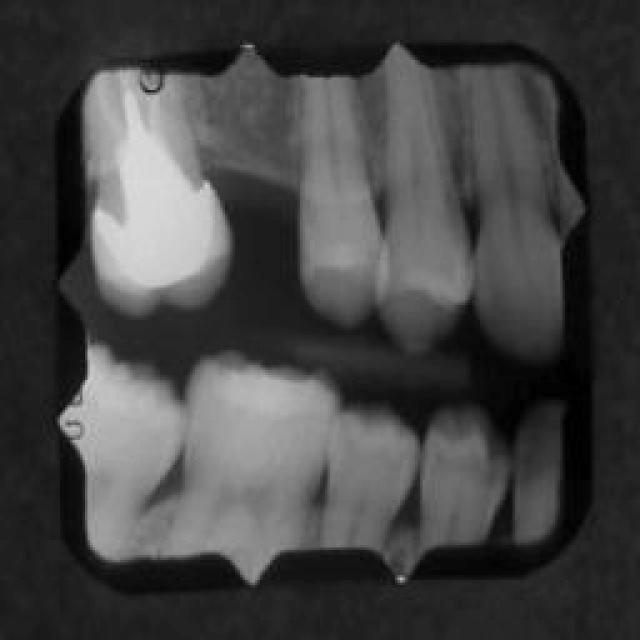


image 1/1 /kaggle/input/toothdecaydetection/test/images/92_jpg.rf.37aaa39ffee2a91758935d5a686a3d17.jpg: 640x640 (no detections), 8.4ms
Speed: 1.3ms preprocess, 8.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


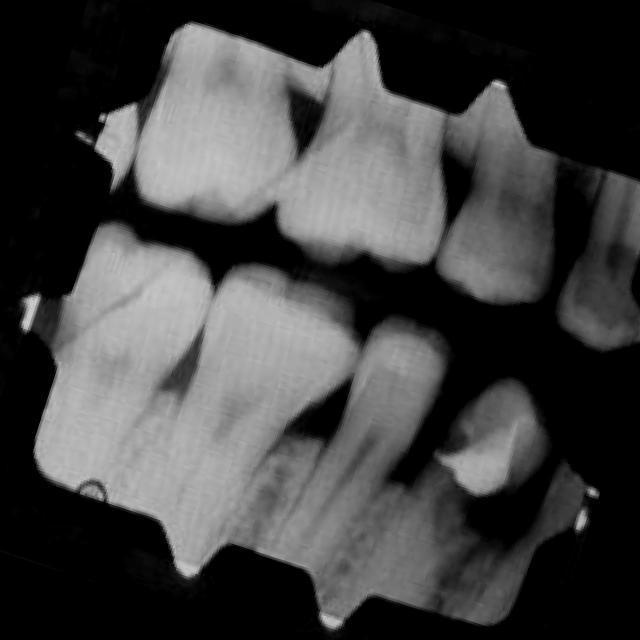


image 1/1 /kaggle/input/toothdecaydetection/test/images/7_png_jpg.rf.e6447ac8726fe19aefb4ba9469fba46d.jpg: 640x640 1 Pulpitis_Caries, 8.2ms
Speed: 1.3ms preprocess, 8.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


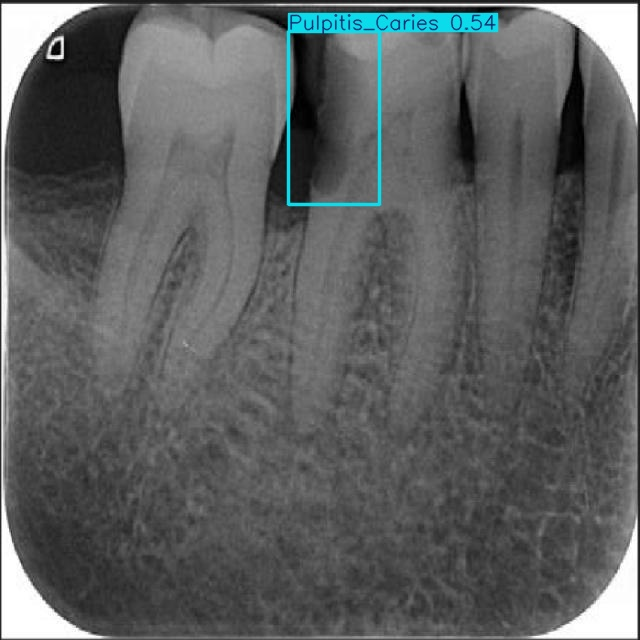


image 1/1 /kaggle/input/toothdecaydetection/test/images/162_png_jpg.rf.a5386671de76c4e431d317888356d26e.jpg: 640x640 1 Pulpitis_Caries, 8.2ms
Speed: 1.3ms preprocess, 8.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


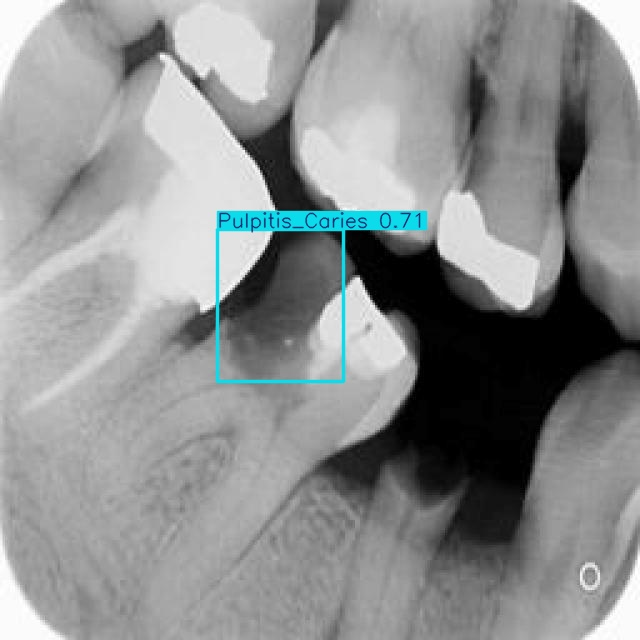

In [27]:
# Evaluate the model and display results
def display_results(model, img_dir, num_images=5):
    images = os.listdir(img_dir)
    sample_images = random.sample(images, num_images)
    save_dir = 'runs/detect/exp'
    os.makedirs(save_dir, exist_ok=True)
    
    for image_name in sample_images:
        image_path = os.path.join(img_dir, image_name)
        results = model(image_path)
        for result in results:
            result.plot(save=True, filename=os.path.join(save_dir, os.path.basename(result.path)))
            result_image_path = os.path.join(save_dir, os.path.basename(result.path))
            display(Image(filename=result_image_path))

print("Displaying results from model trained on version 1 with augmentation:")
display_results(model, os.path.join(v1_dir, 'test/images'))


In [28]:
!ls /kaggle/working/runs/detect/caries_v1_aug/

args.yaml					  train_batch15540.jpg
confusion_matrix_normalized.png			  train_batch15541.jpg
confusion_matrix.png				  train_batch15542.jpg
events.out.tfevents.1738011033.f4ecd7161d43.31.0  train_batch1.jpg
F1_curve.png					  train_batch2.jpg
labels_correlogram.jpg				  val_batch0_labels.jpg
labels.jpg					  val_batch0_pred.jpg
P_curve.png					  val_batch1_labels.jpg
PR_curve.png					  val_batch1_pred.jpg
R_curve.png					  val_batch2_labels.jpg
results.csv					  val_batch2_pred.jpg
results.png					  weights
train_batch0.jpg


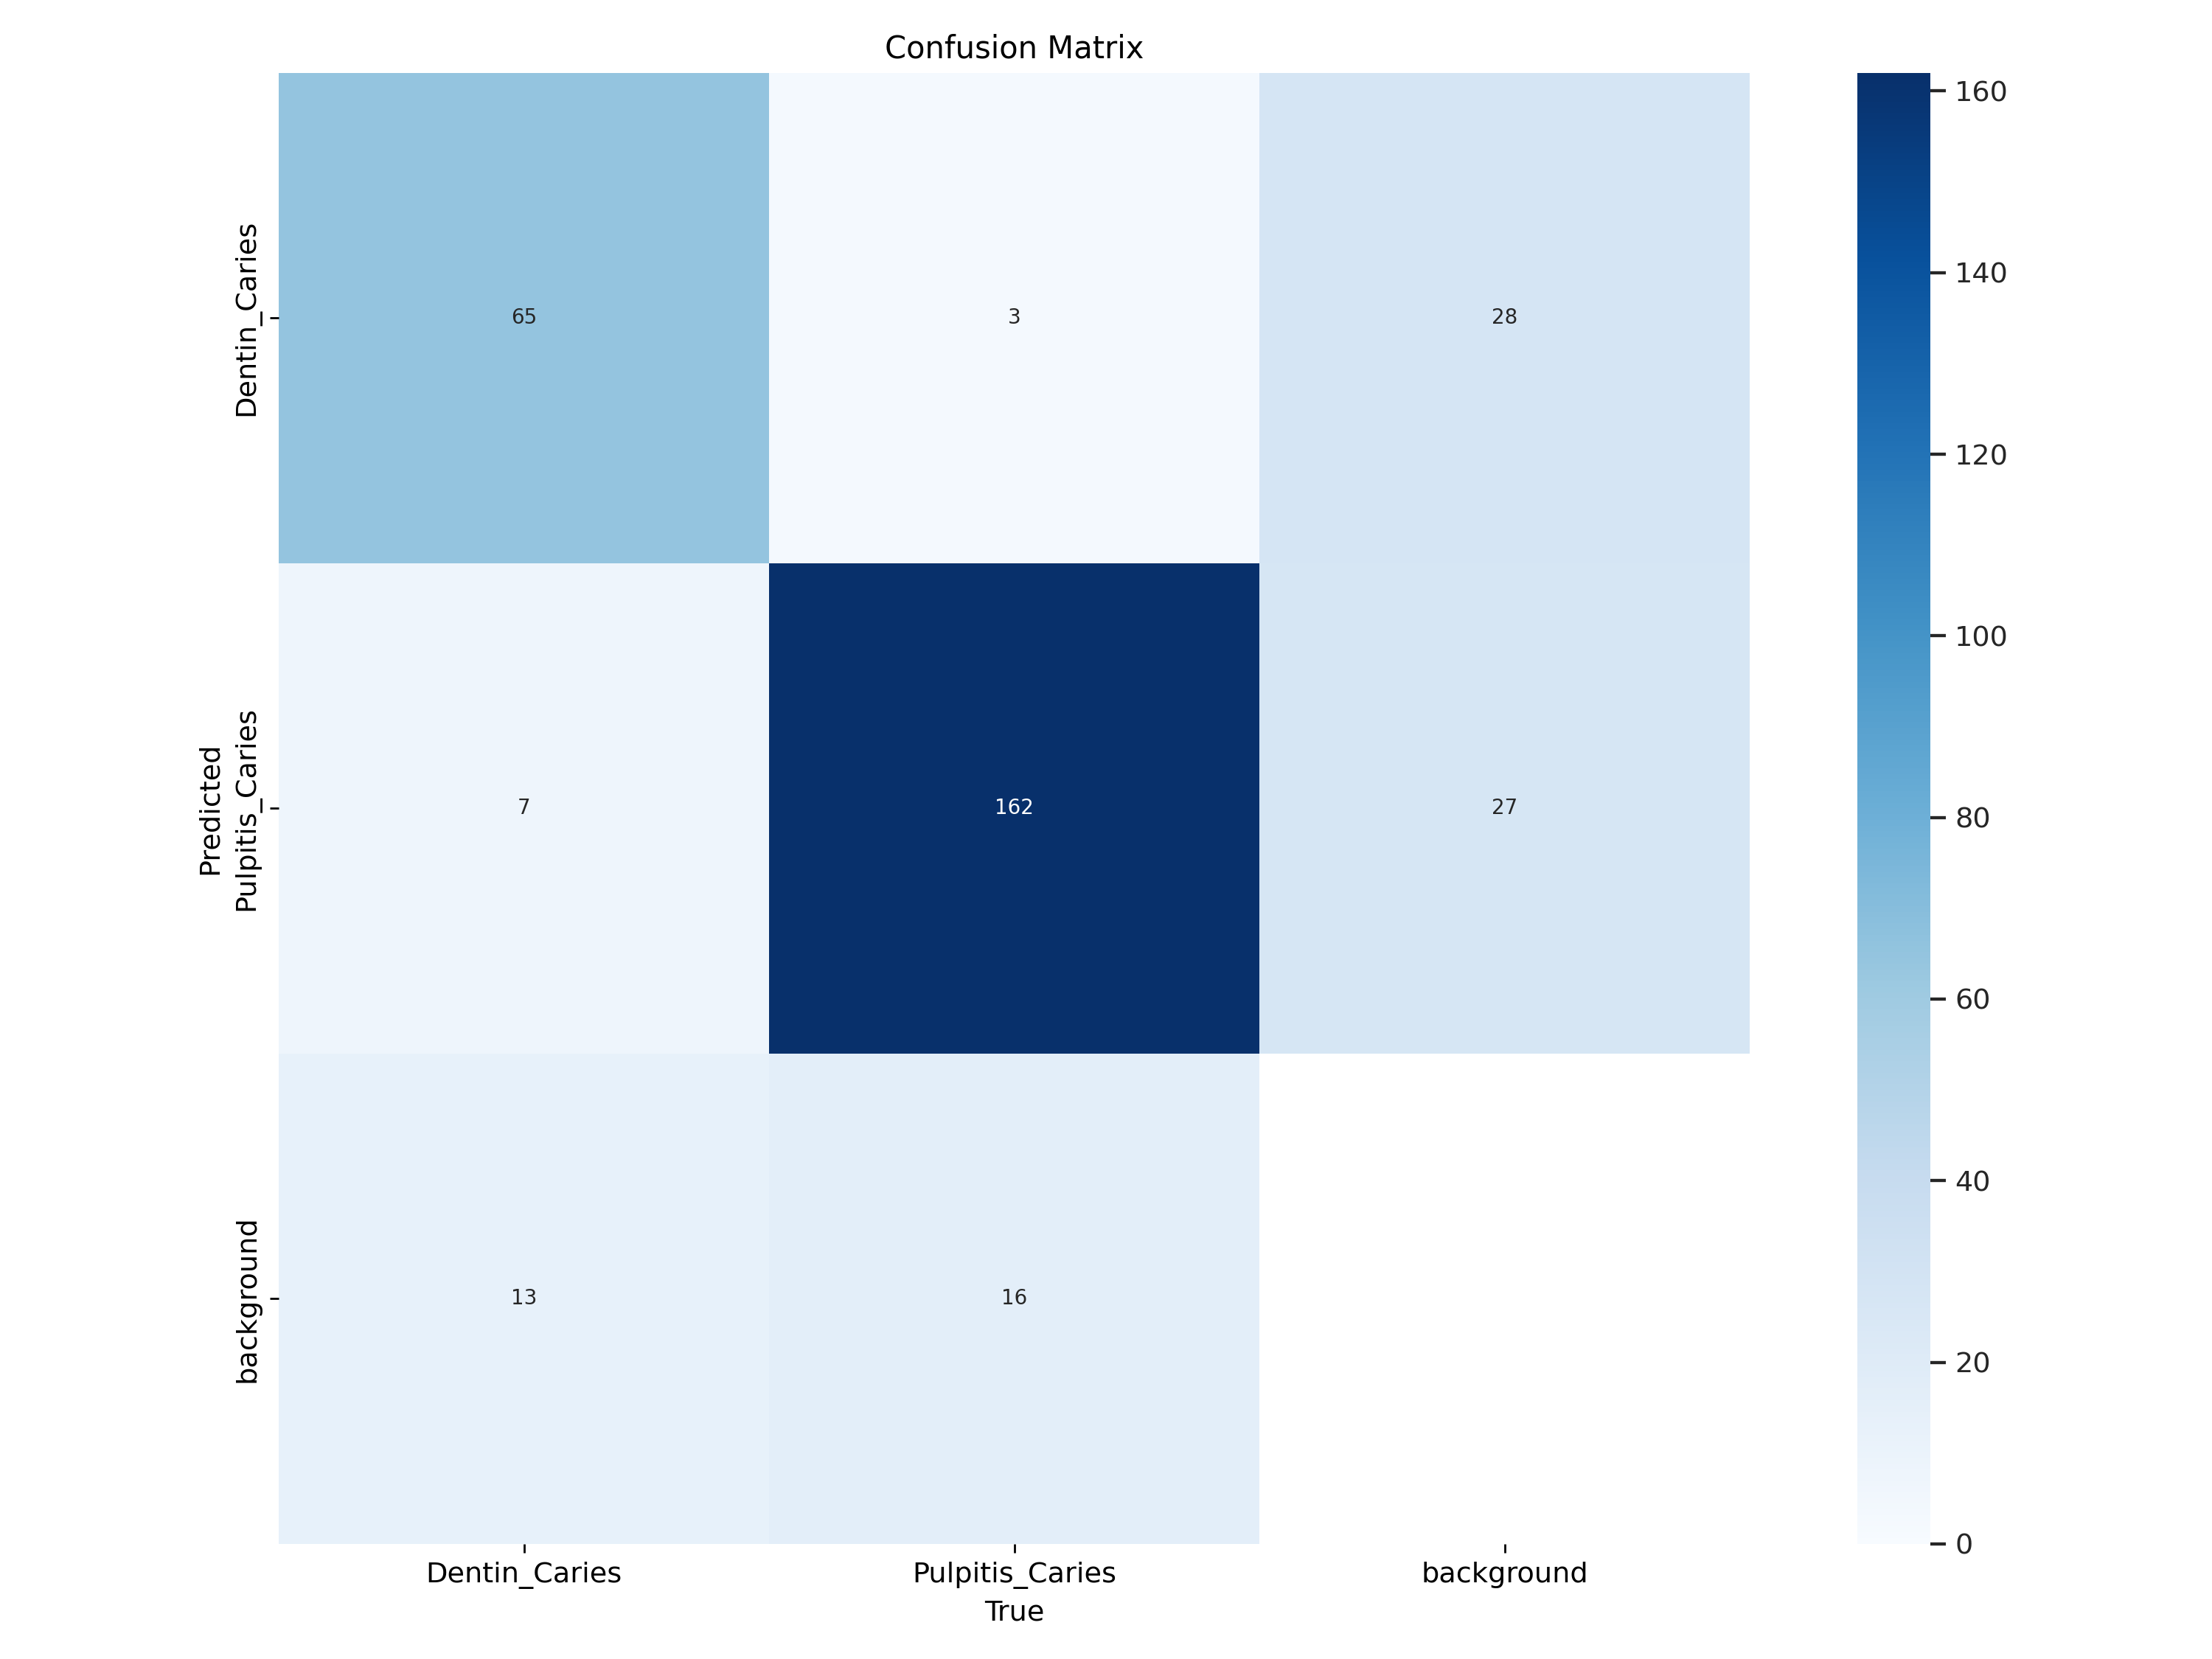

In [29]:
from IPython.display import Image as IPyImage

# Display the confusion matrix image from the specified directory in Kaggle
IPyImage(filename='/kaggle/working/runs/detect/caries_v1_aug/confusion_matrix.png', width=1000)


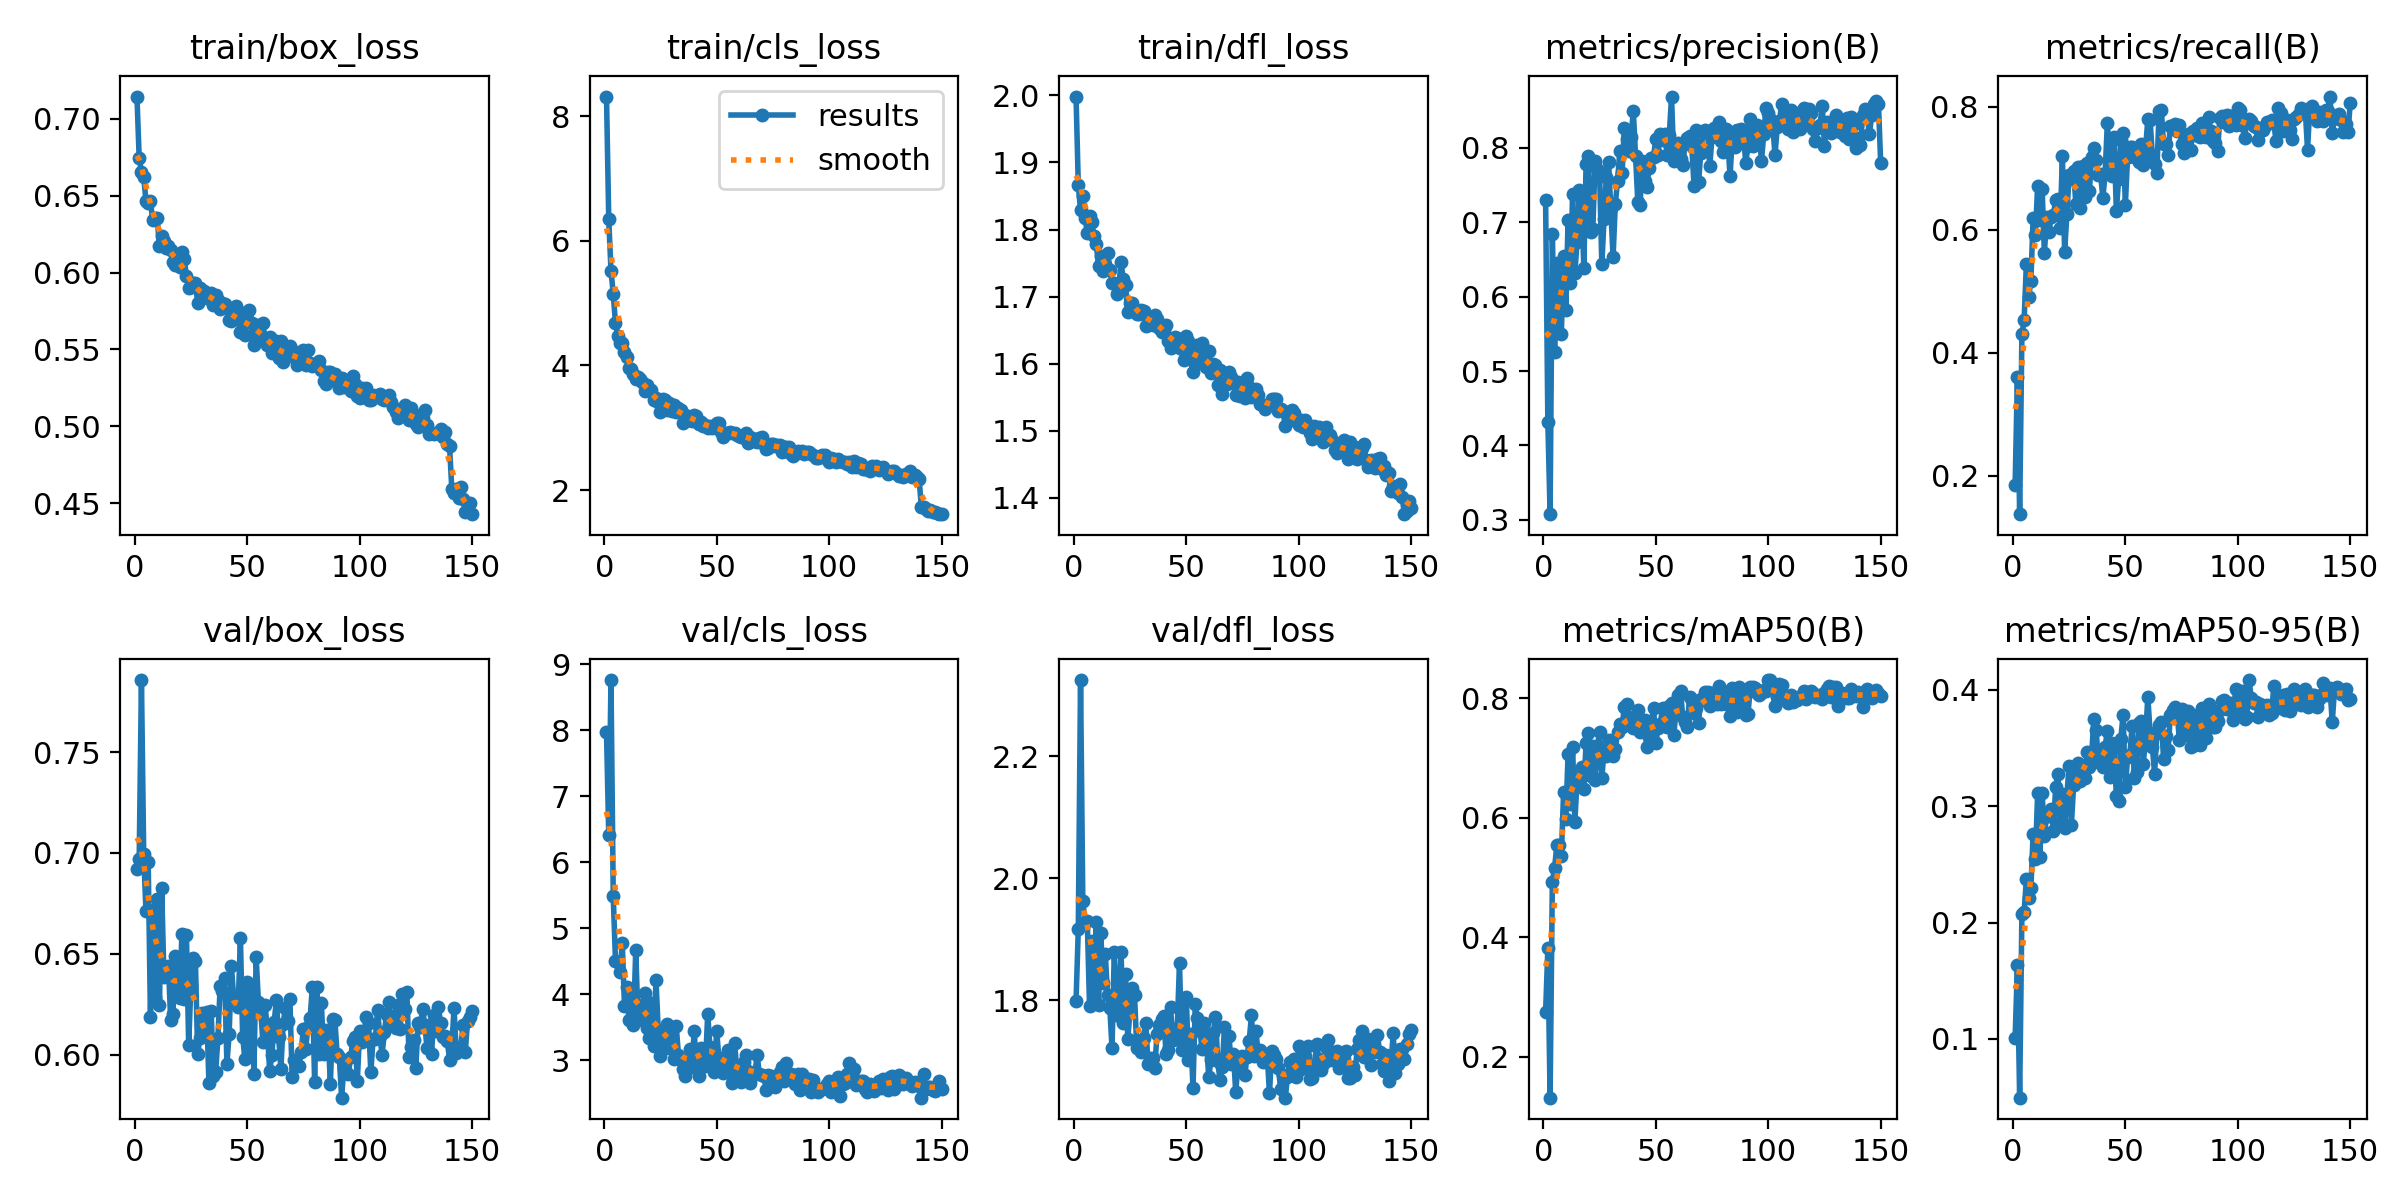

In [30]:
IPyImage(filename=f'/kaggle/working/runs/detect/caries_v1_aug/results.png', width=1000)

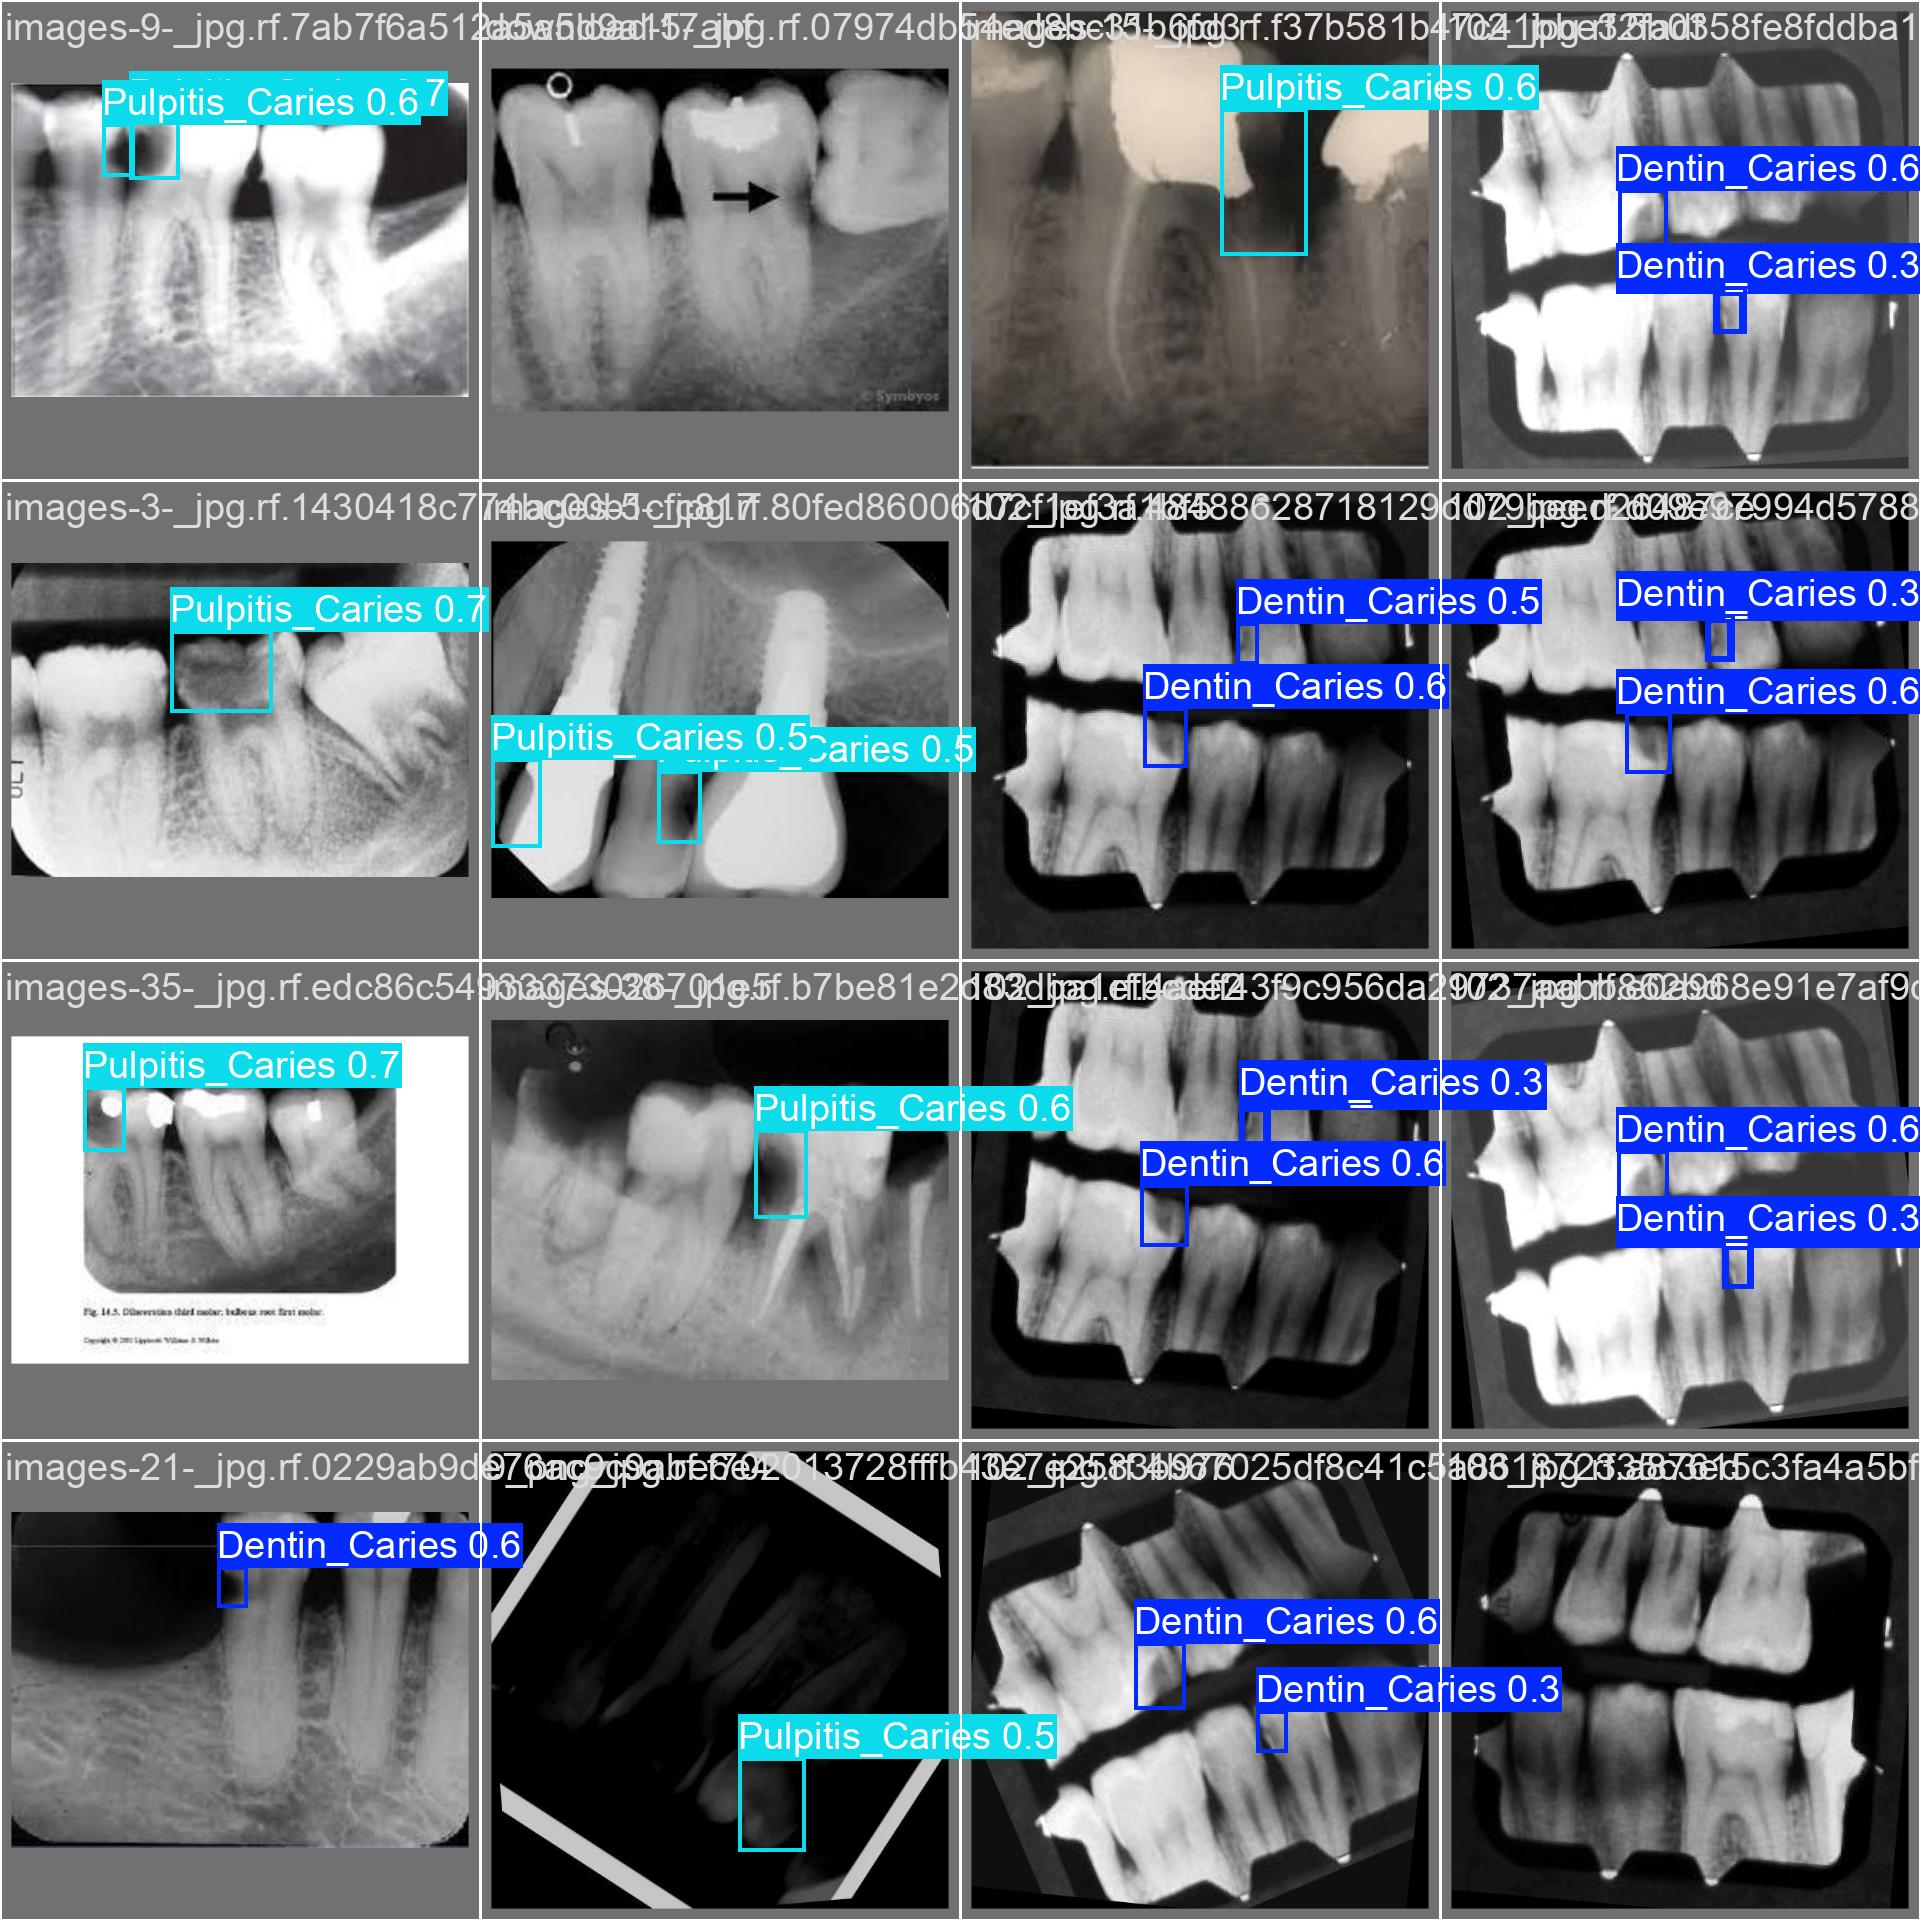

In [31]:
IPyImage(filename=f'/kaggle/working/runs/detect/caries_v1_aug/val_batch0_pred.jpg', width=1000)

In [32]:
# Run the validation task using YOLO in Kaggle
!yolo task=detect mode=val model=/kaggle/working/runs/detect/caries_v1_aug/weights/best.pt data=/kaggle/working/yolov11/data/caries_v1/data.yaml

Ultralytics 8.3.68 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Scanning /kaggle/working/yolov11/data/caries_v1/valid/labels... 169 images,
val: New cache created: /kaggle/working/yolov11/data/caries_v1/valid/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        169        266      0.836       0.78      0.824      0.407
         Dentin_Caries         54         85      0.797      0.671      0.752      0.333
       Pulpitis_Caries        141        181      0.875       0.89      0.897      0.481
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
Speed: 2.1ms preprocess, 3.3ms inference, 0.

In [33]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
log_file_path = "/kaggle/working/runs/detect/caries_v1_aug/results.csv"
logs = pd.read_csv(log_file_path)  # Read log file into a DataFrame

final_losses = logs.iloc[-1]  # Get the last row

# Print final losses
print("Final Losses:")
print(f"Training Box Loss: {final_losses['train/box_loss']}")
print(f"Training Class Loss: {final_losses['train/cls_loss']}")
print(f"Training DFL Loss: {final_losses['train/dfl_loss']}")
print(f"Validation Box Loss: {final_losses['val/box_loss']}")
print(f"Validation Class Loss: {final_losses['val/cls_loss']}")
print(f"Validation DFL Loss: {final_losses['val/dfl_loss']}")

# Print additional metrics
print("\nFinal Metrics:")
print(f"Precision: {final_losses['metrics/precision(B)']}")
print(f"Recall: {final_losses['metrics/recall(B)']}")
print(f"mAP@50: {final_losses['metrics/mAP50(B)']}")
print(f"mAP@50-95: {final_losses['metrics/mAP50-95(B)']}")

Final Losses:
Training Box Loss: 0.44283
Training Class Loss: 1.6129
Training DFL Loss: 1.38499
Validation Box Loss: 0.62187
Validation Class Loss: 2.57144
Validation DFL Loss: 1.75168

Final Metrics:
Precision: 0.7791
Recall: 0.80568
mAP@50: 0.80303
mAP@50-95: 0.39251


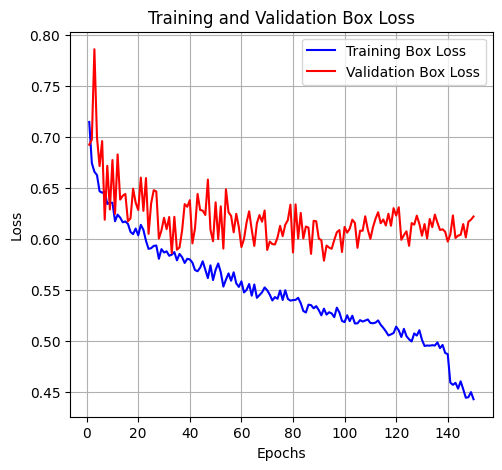

In [34]:
plt.figure(figsize=(12, 5))

# Plot training box loss
plt.subplot(1, 2, 1)
plt.plot(logs['epoch'], logs['train/box_loss'], label='Training Box Loss', color='blue')
plt.plot(logs['epoch'], logs['val/box_loss'], label='Validation Box Loss', color='red')
plt.title('Training and Validation Box Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

In [35]:
path="/kaggle/input/toothdecaydetection/test/images/12_jpg.rf.c13b36f92087a55ec4c6a0547d26d531.jpg"
#prediction on a single image
results = model.predict(source=path,show_labels=False)


image 1/1 /kaggle/input/toothdecaydetection/test/images/12_jpg.rf.c13b36f92087a55ec4c6a0547d26d531.jpg: 640x640 1 Pulpitis_Caries, 11.8ms
Speed: 2.3ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


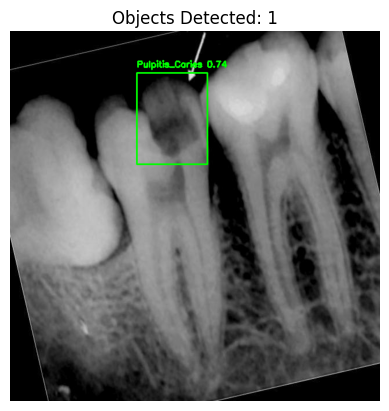

In [36]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread(path)

# Loop through detection results
for result in results:
    boxes = result.boxes  # Get the bounding boxes
    for box in boxes:
        # Extract bounding box coordinates, confidence, and class id
        x1, y1, x2, y2 = box.xyxy[0].int().tolist()
        conf = box.conf[0].item()
        cls = box.cls[0].item()
        
        # Generate label with class name and confidence
        label = f'{model.names[int(cls)]} {conf:.2f}'
        
        # Draw bounding box and label on the image
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green rectangle
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, (0, 255, 0), 2)  # Green text above the box

# Convert BGR image to RGB for displaying with matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.title(f"Objects Detected: {len(boxes)}")
plt.imshow(image_rgb)
plt.axis('off')
plt.show()


In [37]:
!git clone https://github.com/rigvedrs/YOLO-V8-CAM.git

Cloning into 'YOLO-V8-CAM'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 115 (delta 13), reused 8 (delta 8), pack-reused 94 (from 1)
Receiving objects: 100% (115/115), 41.00 MiB | 44.34 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [38]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch    
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
import torchvision.transforms as transforms
from PIL import Image
import io

In [39]:
!ls

runs  yolo11n.pt  yolov11  YOLO-V8-CAM


In [40]:
%cd /kaggle/working/YOLO-V8-CAM

/kaggle/working/YOLO-V8-CAM


In [41]:
!pip install ttach

In [42]:
from yolo_cam.eigen_cam import EigenCAM
from yolo_cam.utils.image import show_cam_on_image, scale_cam_image

In [43]:
img = cv2.imread('/kaggle/input/toothdecaydetection/test/images/12_jpg.rf.c13b36f92087a55ec4c6a0547d26d531.jpg')
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255

In [44]:
model.cpu()

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
    

In [58]:
target_layers =[model.model.model[-4]]

In [59]:
cam = EigenCAM(model, target_layers,task='od')


0: 640x640 1 Pulpitis_Caries, 91.1ms
Speed: 3.9ms preprocess, 91.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


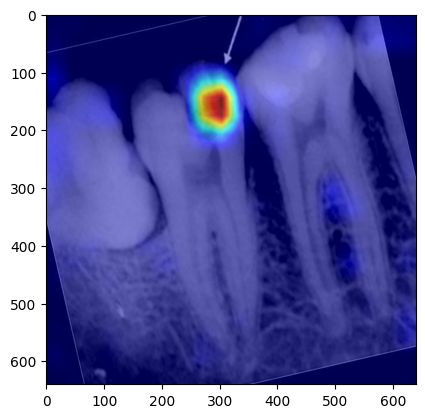

In [60]:
grayscale_cam = cam(rgb_img)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(cam_image)
plt.show()

In [61]:
target_layers =[model.model.model[-5]]

In [72]:
cam = EigenCAM(model, target_layers,task='od')
grayscale_cam = cam(rgb_img)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(cam_image)
plt.show()

AttributeError: 'tuple' object has no attribute 'cpu'

In [70]:
target_layers =[model.model.model[-2],model.model.model[-3], model.model.model[-4],model.model.model[-5]]


In [71]:
cam = EigenCAM(model, target_layers,task='od')
grayscale_cam = cam(rgb_img)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(cam_image)
plt.show()

AttributeError: 'tuple' object has no attribute 'cpu'

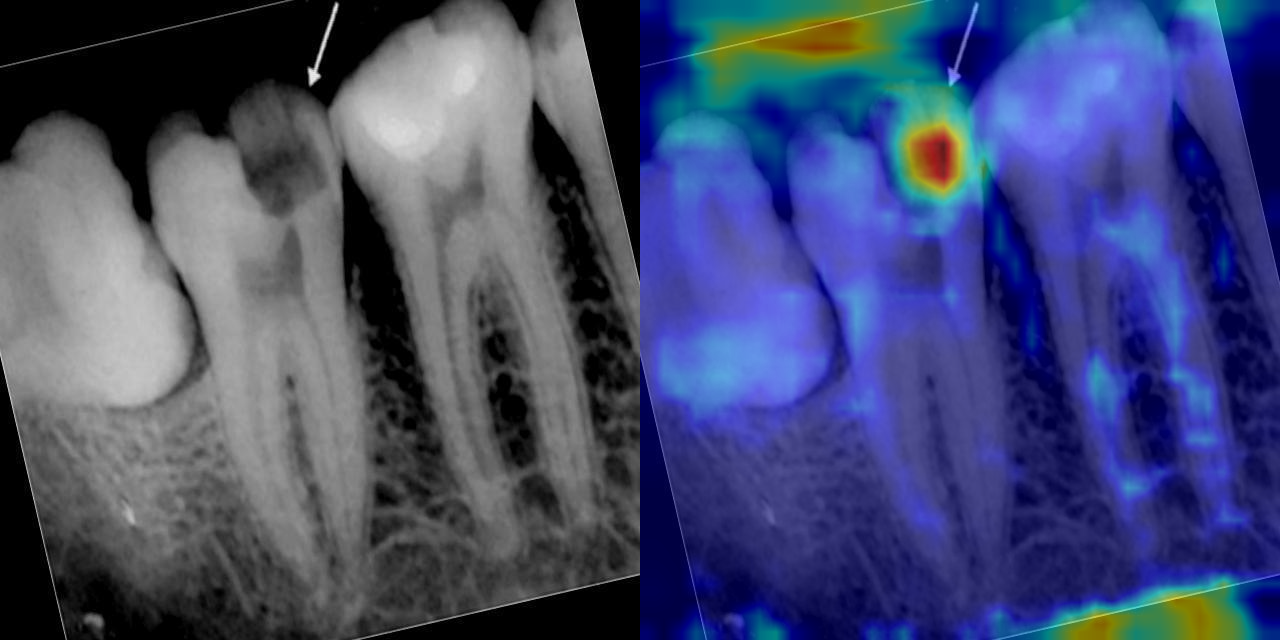

In [65]:
im = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR)
Image.fromarray(np.hstack((im, cam_image)))

In [53]:
list_of_metrics = ["R_curve.png", "confusion_matrix.png", "results.png"]

In [54]:
%cd /kaggle/working/

/kaggle/working


In [55]:
import os
HOME = os.getcwd()
print(HOME)

/kaggle/working


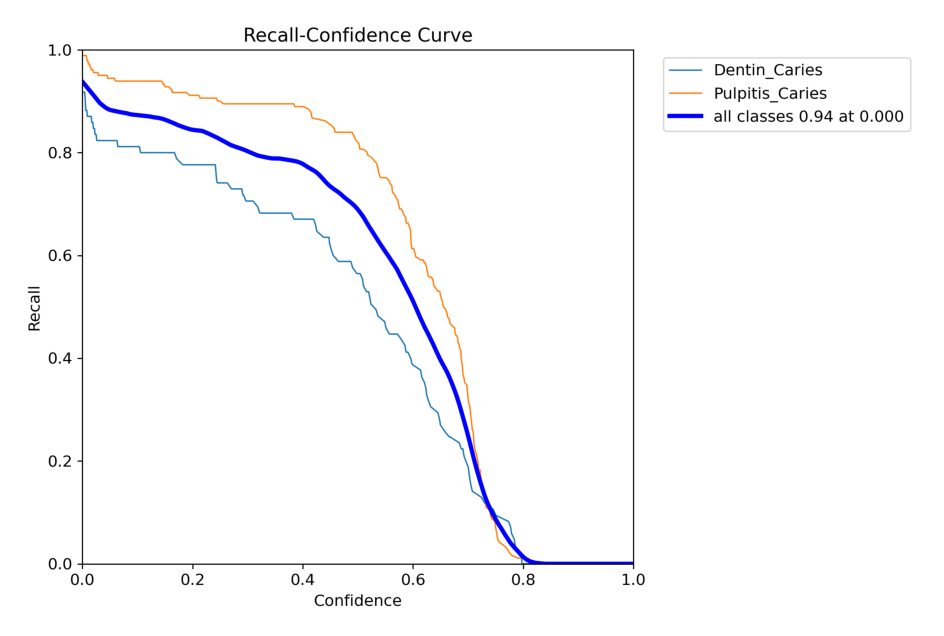

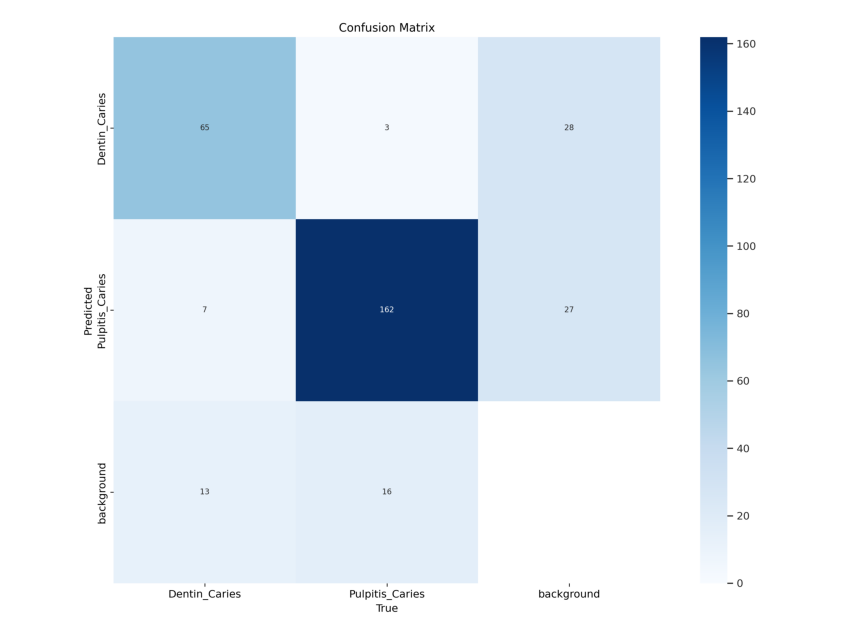

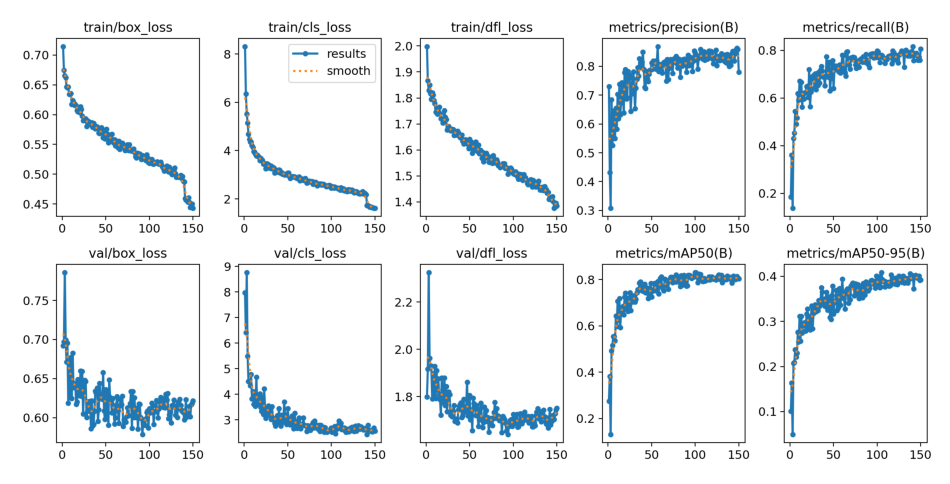

In [56]:
from PIL import Image
for i in list_of_metrics:

    image = Image.open(f'{HOME}/runs/detect/caries_v1_aug/{i}')

    plt.figure(figsize=(12, 8))
    plt.axis("off")
    plt.imshow(image)
    plt.show()
